# Machine learning to predict new crescent moon visibility

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING IMPORTS
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer

## Reading in data

In [2]:
#METHOD = False # replace seen column with method seen column
MULTI_OUTPUT_METHOD = False #Replace naked eye seen column with array of methods
MULTI_LABEL_METHOD = True #Replace naked eye seen column with either seen, visual aid or not seen
XGBOOST = False #Use xgboost forest or random forest
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best random forest hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy
LINUX = True #Use linux file paths


TITLE = f"{'XGBoost' if XGBOOST else 'Random Forest'} {'Eye' if not MULTI_LABEL_METHOD and not MULTI_OUTPUT_METHOD else ''}{'Multi-label' if MULTI_LABEL_METHOD else ''}{'Multi-output' if MULTI_OUTPUT_METHOD else ''} visibility"
print(TITLE)

Random Forest Multi-label visibility


In [3]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

if LINUX:
    icouk_data_file = '../Data/icouk_sighting_data_with_params.csv'
    icop_data_file = '../Data/icop_ahmed_2020_sighting_data_with_params.csv'
    alrefay_data_file = '../Data/alrefay_2018_sighting_data_with_params.csv'
    allawi_data_file = '../Data/schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)

data = pd.concat([icouk_data,icop_data,alrefay_data,allawi_data])

print(f"Loaded {data.shape[0]} rows")

#Drop index, dependent parameters (q value etc) and visibility scale
data = data.drop(["Index","q","W","q'","W'","Visibility"], axis = 1)

if MULTI_OUTPUT_METHOD:
    data = data.drop(["Seen", "Method"], axis = 1) # replaced by methods column

    ptype = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd","Not_seen"]

elif MULTI_LABEL_METHOD:
    data = data.drop(["Seen", "Methods"], axis = 1) # replaced by method column
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    ptype = ["Seen_eye", "Seen_with_aid", "Not_seen"]

else:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1) #Only use seen

    ptype = ["Seen", "Not_seen"]

if RANDOM:
    data.insert(1,"Random1",np.random.rand(data.shape[0],1))
    data.insert(2,"Random2",np.random.rand(data.shape[0],1))
    data = data[['Seen', "Random1","Random2"]]

if CLOUDCUT:
    data = data[data["Cloud Level"] <= 0.5]

data.head(5)

Loaded 3626 rows


,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Cloud Level,Method
0,2.457309e+06,53.95763,-1.08271,0.722,2.457309e+06,2.457309e+06,27.05935,1.51838,252.00232,-1.73173,259.02584,0.00271,0.99508,7.73820,3.25011,7.02353,0.00455,54.14174,1.0,Not_seen
1,2.457339e+06,53.95763,-1.08271,1.687,2.457339e+06,2.457339e+06,57.80819,3.36486,235.23797,-3.31808,243.97528,0.00266,0.98725,10.99616,6.68294,8.73731,0.00918,55.04632,0.5,Not_seen
2,2.457398e+06,53.95763,-1.08271,0.685,2.457398e+06,2.457398e+06,67.20869,3.82122,233.19221,-3.52379,236.46999,0.00252,0.98095,8.04228,7.34501,3.27778,0.00492,58.03155,0.5,Not_seen
3,2.457428e+06,53.58333,-2.43333,1.738,2.457428e+06,2.457428e+06,94.68585,6.40548,245.47535,-5.81151,253.06492,0.00244,0.98427,14.37485,12.21699,7.58956,0.01565,59.59324,1.0,Not_seen
4,2.457428e+06,52.63860,-1.13169,1.736,2.457428e+06,2.457428e+06,93.09817,6.46498,246.07108,-5.86126,253.40983,0.00244,0.98427,14.33820,12.32624,7.33875,0.01557,59.58563,0.0,Seen_eye


## Visualising variables

In [4]:
# Visualising a couple of variables.
variable_list =  data.columns.tolist()
print(variable_list)

# Plot data
showpairplot = False
if showpairplot == True:
   fig = sns.pairplot(data[variable_list], hue = 'Seen', palette = 'bright')

   # Change location of legend
   fig._legend.set_bbox_to_anchor((1.05, 0.5))

   # Add legend
   for t, l in zip(fig._legend.texts, ptype):
      t.set_text(str(t.get_text()) + " - " + str(l))

   plt.show()


['Date', 'Latitude', 'Longitude', 'Moon Age', 'Sunset', 'Moonset', 'Lag', 'Moon Alt', 'Moon Az', 'Sun Alt', 'Sun Az', 'Moon-Earth Dist', 'Sun-Moon Dist', 'ARCL', 'ARCV', 'DAZ', 'Illumination', 'Parallax', 'Cloud Level', 'Method']


## ML Training

In [5]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list


if MULTI_OUTPUT_METHOD:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Methods')
    # test = pd.DataFrame(y, columns=mlb.classes_)
    # print(test.head(10))

elif MULTI_LABEL_METHOD:
    #if XGBOOST:
    data["Method"] = data["Method"].replace("Seen_eye",2) #XGboost needs 1 and 0
    data["Method"] = data["Method"].replace("Seen_with_aid",1)
    data["Method"] = data["Method"].replace("Not_seen",0)
    y = np.array(data['Method'])
    features.remove('Method')
    
else:
    if XGBOOST:
        data["Seen"] = data["Seen"].replace("Seen",1) #XGboost needs 1 and 0
        data["Seen"] = data["Seen"].replace("Not_seen", 0)
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [6]:
# Produce randomforest classifier model and fit to training data
if XGBOOST:
    if MULTI_OUTPUT_METHOD:
        model = XGBClassifier(tree_method="hist") #, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
    else:
        model = XGBClassifier(max_depth=5, learning_rate=1)
else:
    if MULTI_OUTPUT_METHOD:
        model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100,n_jobs=-1))#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
    else:
        model = RandomForestClassifier(n_estimators=100,n_jobs=-1)
# Fitting takes the input and "truth" data for classification purposes
model.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [7]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_pred = model.predict(x_train)

# plot the accuracies of said predictions
print("Accuracy on training dataset:",accuracy_score(y_train, y_pred))
rf_acc_train = accuracy_score(y_train, y_pred)
y_pred = model.predict(x_test)

print("Accuracy on testing dataset:", accuracy_score(y_test, y_pred))
rf_acc_test = accuracy_score(y_test, y_pred)

if MULTI_OUTPUT_METHOD:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_pred)))



Accuracy on training dataset: 0.996551724137931
Accuracy on testing dataset: 0.8236914600550964


## ROC curve

In [8]:
# Get predicted class probabilities for the test set 
if MULTI_OUTPUT_METHOD:
    #y_pred_prob = rf.predict_proba(x_test)
    #roc_auc = roc_auc_score(y_test, y_pred_prob)
    print("Not currently working")
elif MULTI_LABEL_METHOD:
    y_pred_prob = model.predict_proba(x_test)
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    print(f"ROC curve {roc_auc}")
else:
    y_pred_prob = model.predict_proba(x_test)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC curve {roc_auc}")



ROC curve 0.9230673302018032


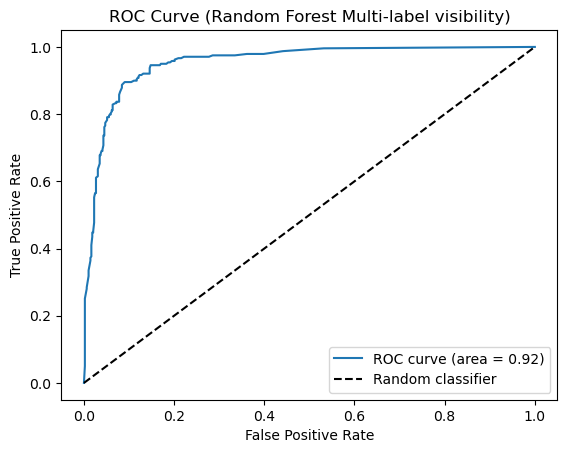

In [9]:
if MULTI_OUTPUT_METHOD:
    # roc curve for Multi classes 
    colors = ['orange','red','green','blue','purple'] 
    #for i in range(len(ptype)):     
    #    fpr, tpr, thresh = roc_curve(y_test, y_pred_prob[:,i], pos_label=ptype[i]) 
    #    plt.plot(fpr, tpr, linestyle='--',color=colors[i], label=ptype[i]+' vs Rest') 
    # roc curve for tpr = fpr  
    #plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    #plt.title('Multiclass ROC curve') 
    #plt.xlabel('False Positive Rate') 
    #plt.ylabel('True Positive rate') 
    #plt.legend() 
    #plt.show()
    print("Not currently working")
else:
    # Compute the false positive rate (FPR) 
    # and true positive rate (TPR) for different classification thresholds
    if MULTI_LABEL_METHOD:
        pos = 2
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,2], pos_label=pos)
    else:
        if XGBOOST:
            pos = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=pos)
    # Plot the ROC curve 
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) 
    # roc curve for tpr = fpr  
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(f'ROC Curve ({TITLE})') 
    plt.legend(loc="lower right") 
    plt.show()

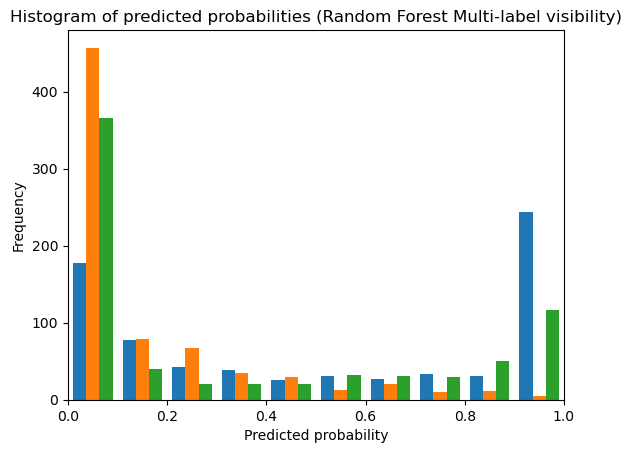

In [10]:
# Plot the predicted class probabilities 
if not MULTI_OUTPUT_METHOD:
    plt.hist(y_pred_prob, bins=10) 
    plt.xlim(0, 1) 
    plt.title(f'Histogram of predicted probabilities ({TITLE})') 
    plt.xlabel('Predicted probability') 
    plt.ylabel('Frequency') 
    plt.show() 

In [11]:
if REPEAT_ACCURACY:
    # Function to run thr random forest several times to get an average
    def random_forest(x_train, y_train, x_test, y_test, rf):
        accuracy_arr = []
        for i in range(20):
            # Fitting takes the input and "truth" data for classification purposes
            rf.fit(x_train, y_train)
            # Produce predictions for the classification of your training dataset using your model:
            y_pred = rf.predict(x_test)
            #print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred))
            accuracy_arr.append(accuracy_score(y_test, y_pred))
        
        accuracy_avg = np.mean(accuracy_arr)
        accuracy_std = np.std(accuracy_arr)
        return accuracy_avg,accuracy_std

    rf = RandomForestClassifier(n_estimators=100, criterion='gini')#, criterion = 'gini', max_depth=12,random_state=0, oob_score=True)
    accuracy_val=random_forest(x_train, y_train, x_test, y_test, rf)

    print(r"When run 20 times the accuracy is {:.5} \pm {:.5}:".format(accuracy_val[0],accuracy_val[1]))

In [12]:
print('Oob Score: ', model.score(x_test, y_test))

Oob Score:  0.8236914600550964


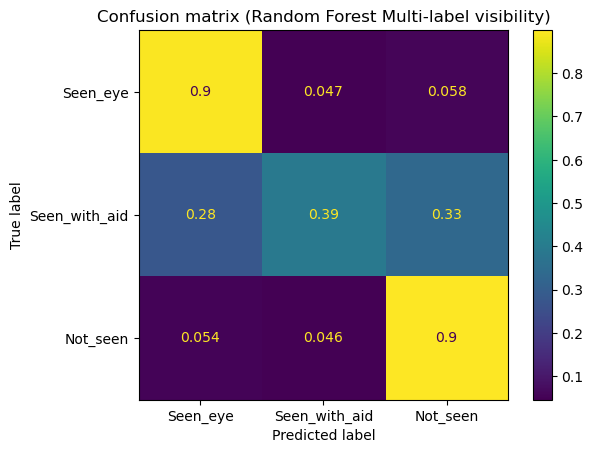

In [13]:
# plot your confusion matrix
if MULTI_OUTPUT_METHOD:
    cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_pred),normalize = 'true')
else:
    cm = confusion_matrix(y_test, y_pred,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
disp.plot()
plt.title(f"Confusion matrix ({TITLE})")
plt.show()

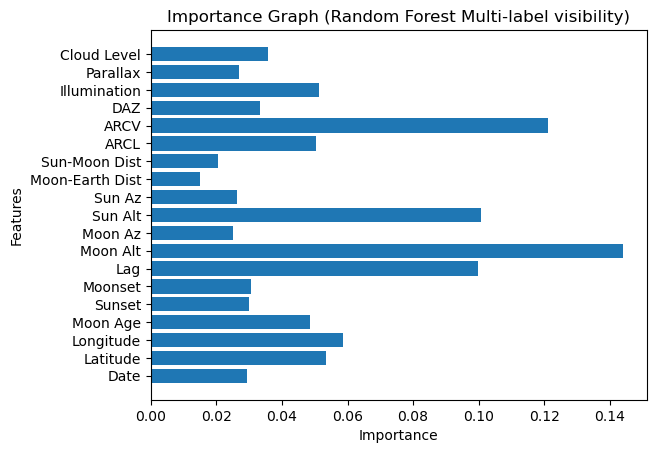

In [14]:
# Plot importance
if not XGBOOST and MULTI_LABEL_METHOD:
    feat_impts = [] 
    for clf in model.estimators_:
        feat_impts.append(clf.feature_importances_) 

    importance = np.mean(feat_impts, axis=0)

else:
    importance = model.feature_importances_

ytix = features
plt.barh(range(len(features)), importance)
plt.yticks(range(len(features)), features)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title(f"Importance Graph ({TITLE})")
plt.show()

Hyperparameter adjustment - not of much note yet

In [15]:
if GRID_SEARCH:
    rf = RandomForestClassifier(random_state=42)

    params = {
        'max_depth': [2,3,5,10,20],
        'min_samples_leaf': [5,10,20,50,100,200],
        'n_estimators': [10,25,30,50,100,200]
    }

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf,
        param_grid=params,
        cv = 4,
         verbose=1, scoring="accuracy")

    grid_search.fit(x_train, y_train)
    grid_search.best_score_
    rf_best = grid_search.best_estimator_
    rf_best

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = rf_best.predict(x_train)

    # plot the accuracies of said predictions
    print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
    rf_best_acc_train = accuracy_score(y_train, y_pred_best)
    y_pred_best = rf_best.predict(x_test)
    print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
    rf_best_acc_train = accuracy_score(y_test, y_pred_best)

In [16]:
#rf_best

In [17]:
#rf_best = grid_search.best_estimator_
#rf_best

In [18]:
# Produce predictions for the classification of your training dataset using your model:
#y_pred_best = rf_best.predict(x_train)

# plot the accuracies of said predictions
#print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
#rf_best_acc_train = accuracy_score(y_train, y_pred_best)
#y_pred_best = rf_best.predict(x_test)
#print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
#rf_best_acc_train = accuracy_score(y_test, y_pred_best)